# fashion-mnist classification

### What is fastai?

In this Notebook I want to show how powerfull fastai can be. I think it is one of the most underrated ML libraries we have.

### Fastai cons

Fastai is great but in some aspects it is very limited:
- There is no great training vis like Tensorboard
- No production tools like TFX
- Pre-trained models are limited. Something like AlexNet or VGG is very very old and you should basically never use it anymore.

In [1]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *

In [2]:
torch.cuda.is_available()

True

In [3]:
path = Path('.')
df = pd.read_csv(Path(path)/'fashion-mnist_train.csv')

### We have to write some custom code to load our data. This is the equivalent to a Dataset in Pytorch.

In [4]:
class MnistImageList(ImageList):
    def open(self, fn):
        img = fn[1:].reshape(28, 28) if len(fn) > 784 else fn.reshape(28, 28)
        img = np.stack((img,) * 3, axis=-1) # To use transfer learning 3 channels are needed.
        
        x = pil2tensor(img, dtype=np.float32)
        x.div_(255)
        return Image(x)

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx=1, header:str='infer', **kwargs) -> 'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        
        df["label"] = df["label"].astype('category')
        df["label"].cat.categories = [
            "T-shirt/top", "Trouser", "Pullover",
            "Dress", "Coat", "Sandal", "Shirt",
            "Sneaker", "Bag", "Ankle boot"]
        
        res = super().from_df(df, path=path, **kwargs)
        res.items = df.iloc[:, imgIdx:].values
        return res

Set of random transforms that have worked well in a wide range of tasks: https://docs.fast.ai/vision.transform.html#get_transforms

In [5]:
transforms = get_transforms()

In [6]:
test = MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_test.csv', imgIdx=None)
data = (MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_train.csv')
                       .split_by_rand_pct(.2)
                       .label_from_df(cols='label')
                       .add_test(test, label=0)
                       .transform(transforms)
                       .databunch(bs=64, num_workers=4)
                       .normalize(imagenet_stats))

## This is how the dataset looks

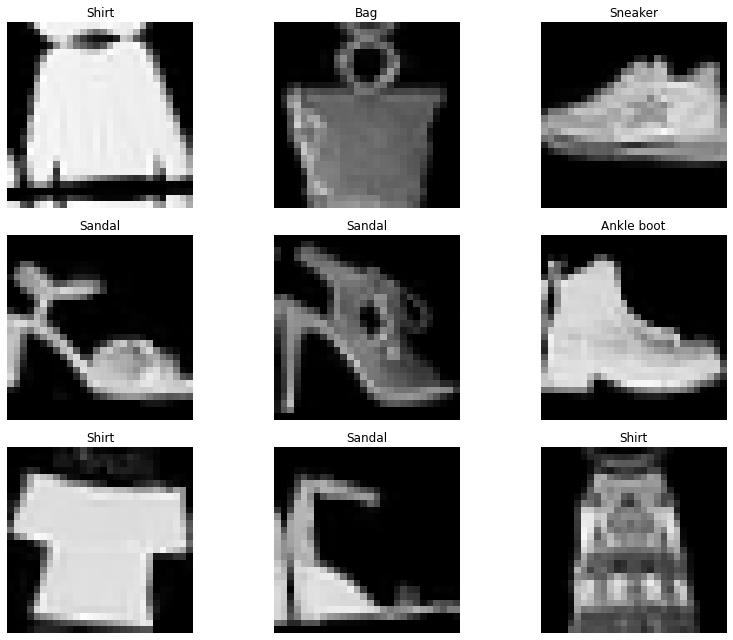

In [7]:
data.show_batch(rows=3, figsize=(12,9))

# Resnet34 

In [8]:
arch = models.resnet34
learn = cnn_learner(data, arch, metrics=[error_rate,accuracy], path='/tmp/models')
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


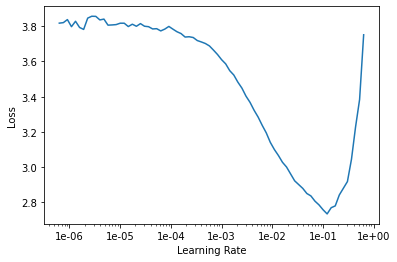

In [9]:
learn.recorder.plot()

In [10]:
lr = 1e-2

### Fit one cycle is a training method only implemented in fastai. https://arxiv.org/pdf/1803.09820.pdf

In [11]:
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.710380,0.538519,0.203167,0.796833,00:24
1,0.590116,0.452991,0.170167,0.829833,00:26
2,0.529825,0.410701,0.148667,0.851333,00:25
3,0.469019,0.504104,0.188833,0.811167,00:23
4,0.422914,0.364205,0.136750,0.863250,00:22
5,0.384832,0.303650,0.114917,0.885083,00:22
6,0.343209,0.286607,0.109000,0.891000,00:22
7,0.357429,0.281948,0.105750,0.894250,00:23


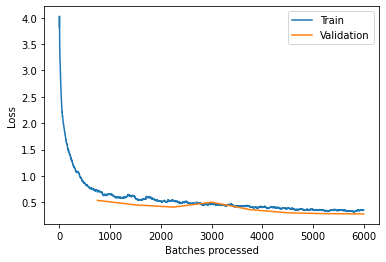

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save('stage-1-resnet32')

In [14]:
learn.load('stage-1-resnet32')

Learner(data=ImageDataBunch;

Train: LabelList (48000 items)
x: MnistImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
Pullover,Ankle boot,Shirt,Coat,Coat
Path: .;

Valid: LabelList (12000 items)
x: MnistImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
Ankle boot,Sandal,T-shirt/top,Dress,Pullover
Path: .;

Test: LabelList (10000 items)
x: MnistImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): C

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


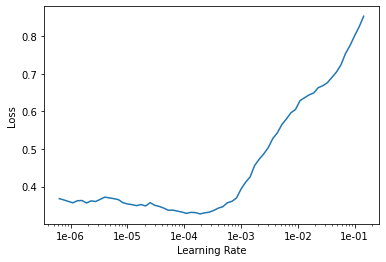

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, lr / 10))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.332764,0.283064,0.105083,0.894917,00:32
1,0.353857,0.279451,0.103750,0.896250,00:32
2,0.339174,0.272848,0.103500,0.896500,00:33
3,0.321623,0.278764,0.105667,0.894333,00:32
4,0.325417,0.268531,0.100417,0.899583,00:33
5,0.307201,0.259989,0.099917,0.900083,00:33
6,0.280876,0.265606,0.102250,0.897750,00:33
7,0.298636,0.260168,0.099667,0.900333,00:33


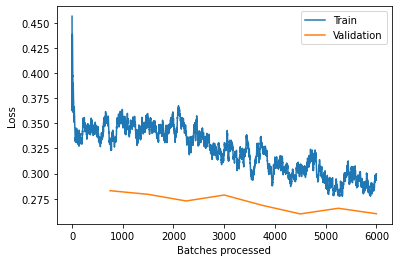

In [19]:
learn.recorder.plot_losses()

### The ClassificationInterpretation is super helpful for quickly checking the performance of the model.

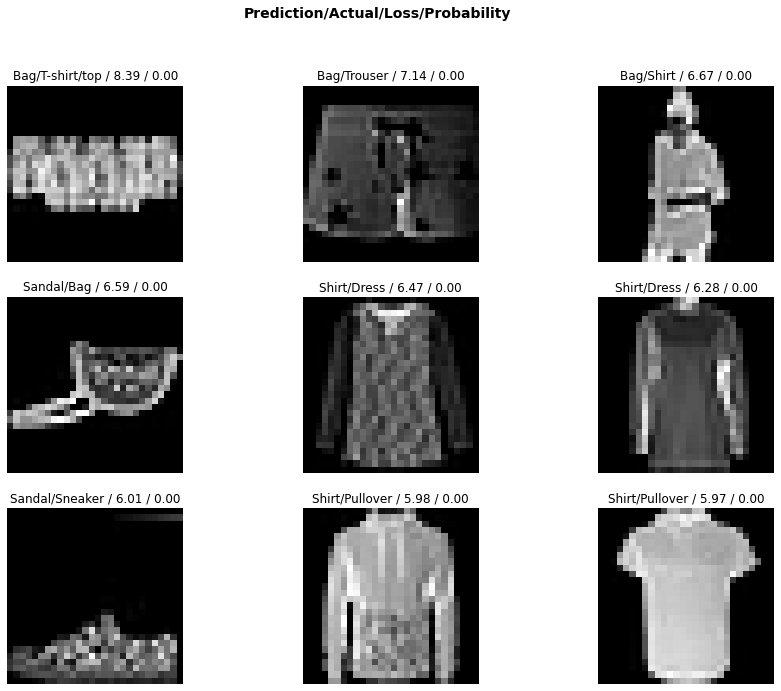

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

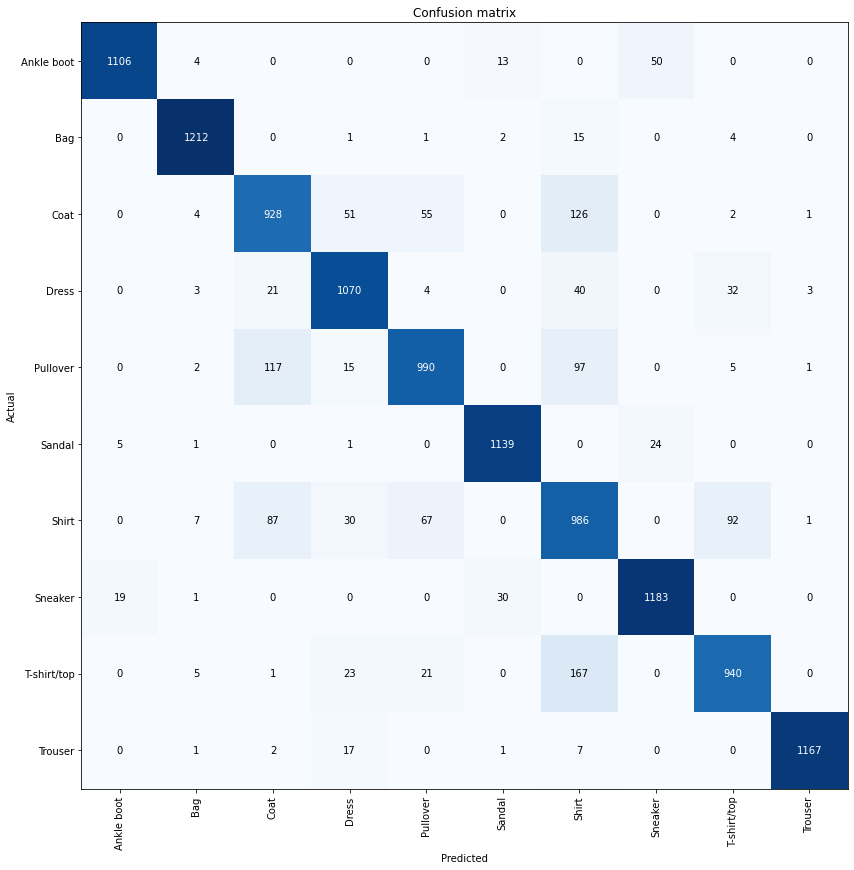

In [23]:
interp.plot_confusion_matrix(figsize=(12,12))

# Resnet-16 with custom augmentations 

In [21]:
transforms = get_transforms(do_flip=False, max_rotate=2, max_zoom=0.5, max_lighting=0.1)

In [22]:
test = MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_test.csv', imgIdx=None)
data = (MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_train.csv')
                       .split_by_rand_pct(.2)
                       .label_from_df(cols='label')
                       .add_test(test, label=0)
                       .transform(transforms)
                       .databunch(bs=64, num_workers=4)
                       .normalize(imagenet_stats))

In [23]:
arch = models.resnet34
learn = cnn_learner(data, arch, metrics=[error_rate,accuracy], path='/tmp/models')
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


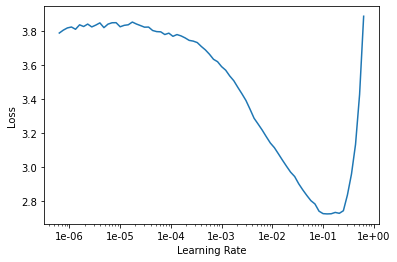

In [24]:
learn.recorder.plot()

In [25]:
lr = 1e-3

In [26]:
learn.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.124318,0.749015,0.265000,0.735000,00:23
1,0.646353,0.473015,0.172333,0.827667,00:23
2,0.487983,0.373816,0.139750,0.860250,00:23
3,0.430323,0.340365,0.127750,0.872250,00:22
4,0.397679,0.318867,0.118500,0.881500,00:23
5,0.359674,0.295903,0.111750,0.888250,00:24
6,0.349443,0.287421,0.107500,0.892500,00:23
7,0.351780,0.284300,0.106833,0.893167,00:22


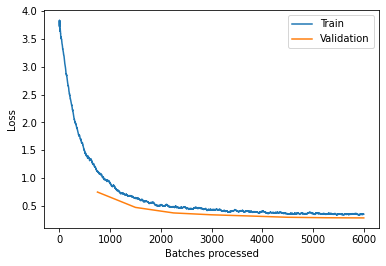

In [27]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-resnet-16')

# Squeezenet with custom augmentations 

In [48]:
transforms = get_transforms(do_flip=True, max_rotate=2.5, max_zoom=.5, p_lighting=0.09)

In [49]:
test = MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_test.csv', imgIdx=None)
data = (MnistImageList.from_csv_custom(path=path, csv_name='fashion-mnist_train.csv')
                       .split_by_rand_pct(.2)
                       .label_from_df(cols='label')
                       .add_test(test, label=0)
                       .transform(transforms)
                       .databunch(bs=64, num_workers=4)
                       .normalize(imagenet_stats))

In [50]:
arch = models.squeezenet1_1
learn = cnn_learner(data, arch, metrics=[error_rate,accuracy], path='/tmp/models')
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


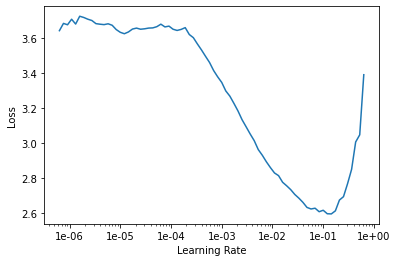

In [51]:
learn.recorder.plot()

In [52]:
lr = 1e-3

In [53]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.008708,0.937922,0.290000,0.710000,00:16
1,0.900415,0.950675,0.287167,0.712833,00:15
2,0.917313,0.929640,0.276000,0.724000,00:16
3,0.872621,0.902761,0.276583,0.723417,00:16
4,0.888798,0.858024,0.271500,0.728500,00:15
5,0.857692,0.907453,0.286917,0.713083,00:17
6,0.880107,1.014071,0.274667,0.725333,00:17
7,0.895640,1.026818,0.264917,0.735083,00:17
8,0.859178,0.989392,0.301917,0.698083,00:16
9,0.832766,0.928882,0.269083,0.730917,00:16


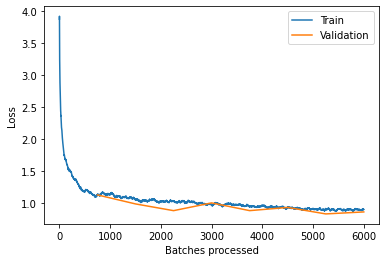

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save('stage-1-squeezenet')

## Summary

I think it is great how fast it is to archieve a "good" accuracy with fastai. Around a 90% accuracy with a Resnet-16 is not that bad. Of course it is not state-of-the-art but quite good.


| Architecture | accuracy |
| --- | --- |
| Resnet-32 | **90.00** |
| Resnet-16 | **89.31** |
| Squeezenet | **75.00** |